# Feature Engineering and (Unsupervised) Preprocessing

---

## Description

In this section, we are going to discover different methods of preprocessing, feature engineering and selection using supervised and unsupervised methods.

---

## Importing Libraries and Loading Data

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../utils')

from MDLP import MDLP_Discretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
df = pd.read_csv('../data/processed/sales_cleaned.csv')
df.head()

,X1_sales_in_vol,X2_sales_in_val,X3_sales,X4_turnover,X5_value,X6_sign,X7_feature,Y_display
0,2.0,20.20,72.0,47400,36,CORA,No_Feat,No_Displ
1,2.0,11.90,48.0,62000,24,LECLERC,No_Feat,No_Displ
2,8.0,29.52,480.0,60661,60,AUCHAN,No_Feat,No_Displ
3,2.0,16.20,38.0,59677,19,CARREFOUR,No_Feat,No_Displ
4,5.0,62.10,250.0,142602,50,CORA,No_Feat,No_Displ


---

## Preprocessing

Before applying any machine learning model on our dataset, we'll want to compare between two versions of the data, one using the original numerical features, and one using a categorical version of these features, by binning them based on the information gain criterion. This process is called MDLPC.

### Discretization

We'll use the MDLP discretizer from this [MDLPC implementation](https://github.com/navicto/Discretization-MDLPC).  
Because of the way the discretizer is implemented, we'll have to separate the numerical features from the categorical ones, and then concatenate them back together after the discretization.

In [3]:
X, y = df.drop('Y_display', axis=1).values, df['Y_display'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train_num, X_train_cat = X_train[:, :5].astype('float'), X_train[:, 5:]
X_test_num, X_test_cat = X_test[:, :5].astype('float'), X_test[:, 5:]

In [5]:
# one-hot encode categorical features
ohe = OneHotEncoder(sparse_output=False)
X_train_cat = ohe.fit_transform(X_train_cat)
X_test_cat = ohe.transform(X_test_cat)

In [6]:
# discretize numerical features
mdlp = MDLP_Discretizer(features=[0, 1, 2, 3, 4])
mdlp.fit(X_train_num, y_train)
X_train_num_discretized = mdlp.transform(X_train_num)
X_test_num_discritized = mdlp.transform(X_test_num)

In [7]:
# combine continuous numerical and discretized numerical features
X_train_num = np.concatenate((X_train_num, X_train_num_discretized), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_num_discritized), axis=1)

# combine numerical and categorical features
X_train = np.concatenate((X_train_num, X_train_cat), axis=1)
X_test = np.concatenate((X_test_num, X_test_cat), axis=1)

In [8]:
np.concatenate((X, y.reshape(-1, 1)), axis=1).shape

(25782, 8)

In [9]:
# combine X_train and X_test
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [10]:
columns = list(df.columns[:5]) + [col+"_disc" for col in df.columns[:5]] + list(ohe.get_feature_names_out(input_features=['X6_sign', 'X7_feature'])) + ['Y_display']
df = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1), columns=columns)

In [11]:
df.head()

,X1_sales_in_vol,X2_sales_in_val,X3_sales,X4_turnover,X5_value,X1_sales_in_vol_disc,X2_sales_in_val_disc,X3_sales_disc,X4_turnover_disc,X5_value_disc,...,X6_sign_GEANT,X6_sign_INTERMARCHE,X6_sign_LECLERC,X6_sign_MONOPRIX,X6_sign_OTHERS,X6_sign_SIMPLY MARKET,X6_sign_SUPER U,X7_feature_Feat,X7_feature_No_Feat,Y_display
0,1.0,22.99,72.0,83553.0,72.0,0.0,1.0,3.0,3.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Displ
1,1.0,9.99,36.0,152340.0,36.0,0.0,1.0,1.0,7.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No_Displ
2,1.0,8.19,40.0,15492.0,40.0,0.0,0.0,1.0,0.0,8.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No_Displ
3,51.0,691.05,2142.0,210096.0,42.0,6.0,7.0,8.0,7.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Displ
4,3.0,8.97,75.0,3069.0,25.0,0.0,1.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,No_Displ


In [12]:
df.to_csv('../data/processed/sales_processed.csv', index=False)

### Analyzing binning results

Let's look at how the discretizer binned our numerical features for a better separation between the classes.

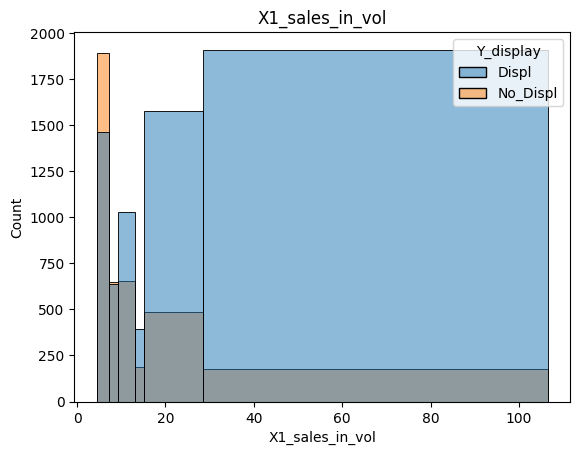

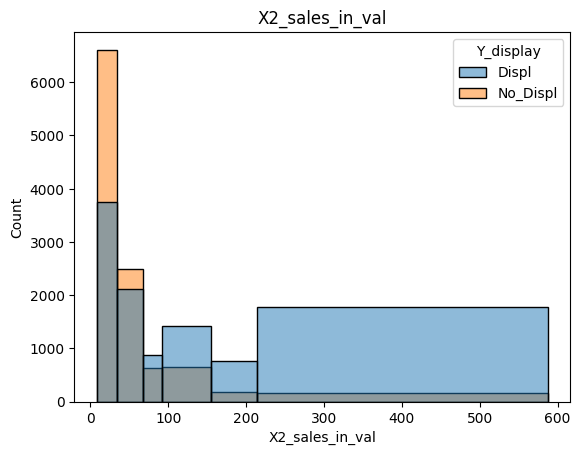

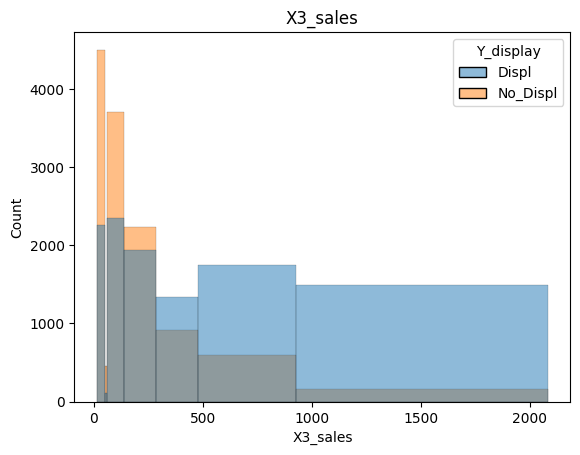

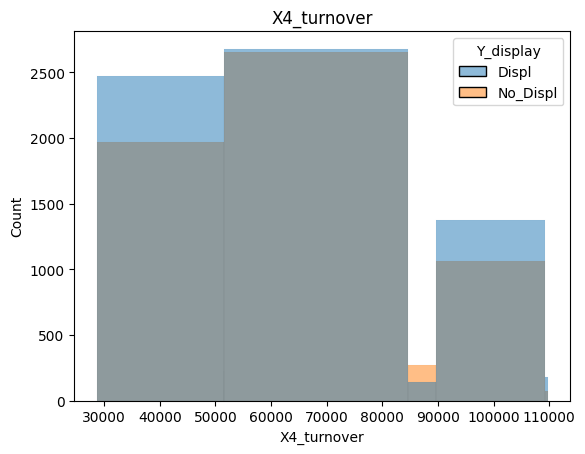

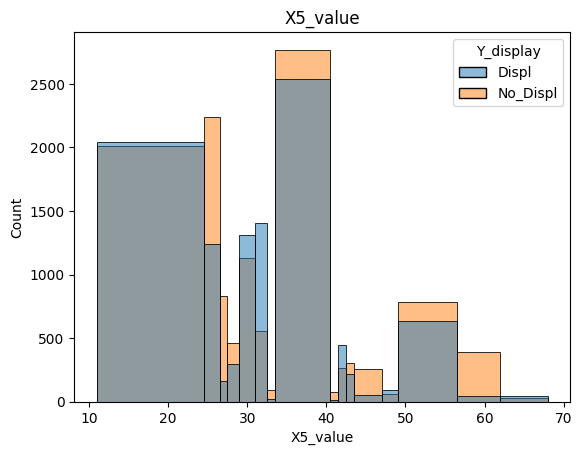

In [13]:
numerical_features = list(df.columns[:5])
for index, feature in enumerate(numerical_features):
    sns.histplot(data=df, x=feature, hue='Y_display', bins=mdlp._cuts[index])
    plt.title(feature)
    plt.show()

We see that for the first three features, the discretizer did a good job at separating the classes, while for the last two features, given the weak correlation between them and the target, we see that some intervals are better than others in terms of class separation, but we don't see a significant difference in the distributions.  
What we can do is to retain the discretization of the first three features, and use the original numerical values for the last two features.  
However, this might lead to a perfect correlation between the first three features, which is not good for our model, but we can solve this by keeping only one of the three features.
Let's examine the correlation between the three features.

In [14]:
df[['X1_sales_in_vol_disc', 'X2_sales_in_val_disc', 'X3_sales_disc']].corr()

,X1_sales_in_vol_disc,X2_sales_in_val_disc,X3_sales_disc
X1_sales_in_vol_disc,1.000000,0.906579,0.844266
X2_sales_in_val_disc,0.906579,1.000000,0.906606
X3_sales_disc,0.844266,0.906606,1.000000


Indeed, we see that the three discretized features are highly correlated.

### t-SNE

We'll use the t-distribution Stochastic Neighboring Embedding in order to visualize our data in a two dimensional space and see if we can derrive any kind of cluster or pattern.  
Our dataset is not very big, so this wouldn't take a lonf time to be ready.

In [32]:
X_embedded = TSNE(random_state=42).fit_transform(df[['X1_sales_in_vol', 'X2_sales_in_val', 'X3_sales', 'X4_turnover', 'X5_value'] + list(ohe.get_feature_names_out(input_features=['X6_sign', 'X7_feature']))])
X_embedded.shape

(25782, 2)

In [33]:
df['TSNE_1'] = X_embedded[:, 0]
df['TSNE_2'] = X_embedded[:, 1]

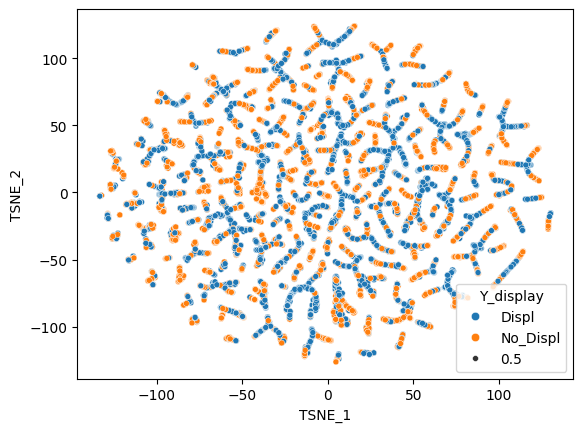

In [34]:
sns.scatterplot(data=df, x='TSNE_1', y='TSNE_2', hue='Y_display', size=0.5)
plt.show()

From the plot above, we see that the TSNE components are not very useful in separating the classes, they only reveal shapes like worms, but we can't really see any clear clusters.

### Clustering

In [36]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
kmeans.fit(df[['X1_sales_in_vol', 'X2_sales_in_val', 'X3_sales', 'X4_turnover', 'X5_value'] + list(ohe.get_feature_names_out(input_features=['X6_sign', 'X7_feature']))])

KMeans(n_clusters=2, n_init='auto', random_state=42)

In [39]:
df['kmeans'] = kmeans.labels_

In [40]:
pd.crosstab(df['Y_display'], df['kmeans'])

kmeans,0,1
Y_display,,
Displ,9295,3487
No_Displ,9404,3596


Clustering using KMeans isn't useful at all.

---

## Conslusion

- We see that the MDLP discretizer did a good job at separating the classes for some features, while for others, it didn't do much, meaning that the associations of these features with the target is low.
- Unsupervised technics like t-SNE and KMeans didn't reveal any useful information about the data or hidden patterns.